In [72]:
# Imports
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.utils.extmath import randomized_svd
from prettytable import PrettyTable

import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from dotenv import dotenv_values 
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
import scipy.io
import pyvista as pv
import h5py
import mat73
from scipy import signal
import control
import dask.array as da
import cvxpy as cp
import opinf


config = dotenv_values(".env")
from util import *

# Read in Data

In [73]:
# Setup filepaths for reading data
filepath = config["currentDirectory"] + "data/verificationData/controlTest26/"
timesteps = 3000# Y_fom.shape[0]

In [74]:
# Load in data from npy file
data = np.load(filepath + "processedData_policySeed_0.npz")

Y_fom = data["reducedCenterlineData"]
U_fom = data["inputData"].T
Y0_fom = data["reducedCenterlineData"][0,:]



# RHC Analysis

In [75]:
# Read in data
# Initialize arrays to store data from online observer
y_groundTruth_online = np.zeros((40, timesteps)) 
y_ref_online = np.zeros((40, timesteps)) 
# Read in data from online observer
for i in range(timesteps):
    onlineObs_filename = filepath + "verification_step_" + str(i) + ".hdf5"
    with h5py.File(onlineObs_filename, 'r') as f:
        y_groundTruth_online[:,i] = f["y"][()].squeeze()
        y_ref_online[:,i] = f["y_ref"][()][:,0].squeeze()


## Control Inputs

The goal here is to analyze the control inputs a given trial

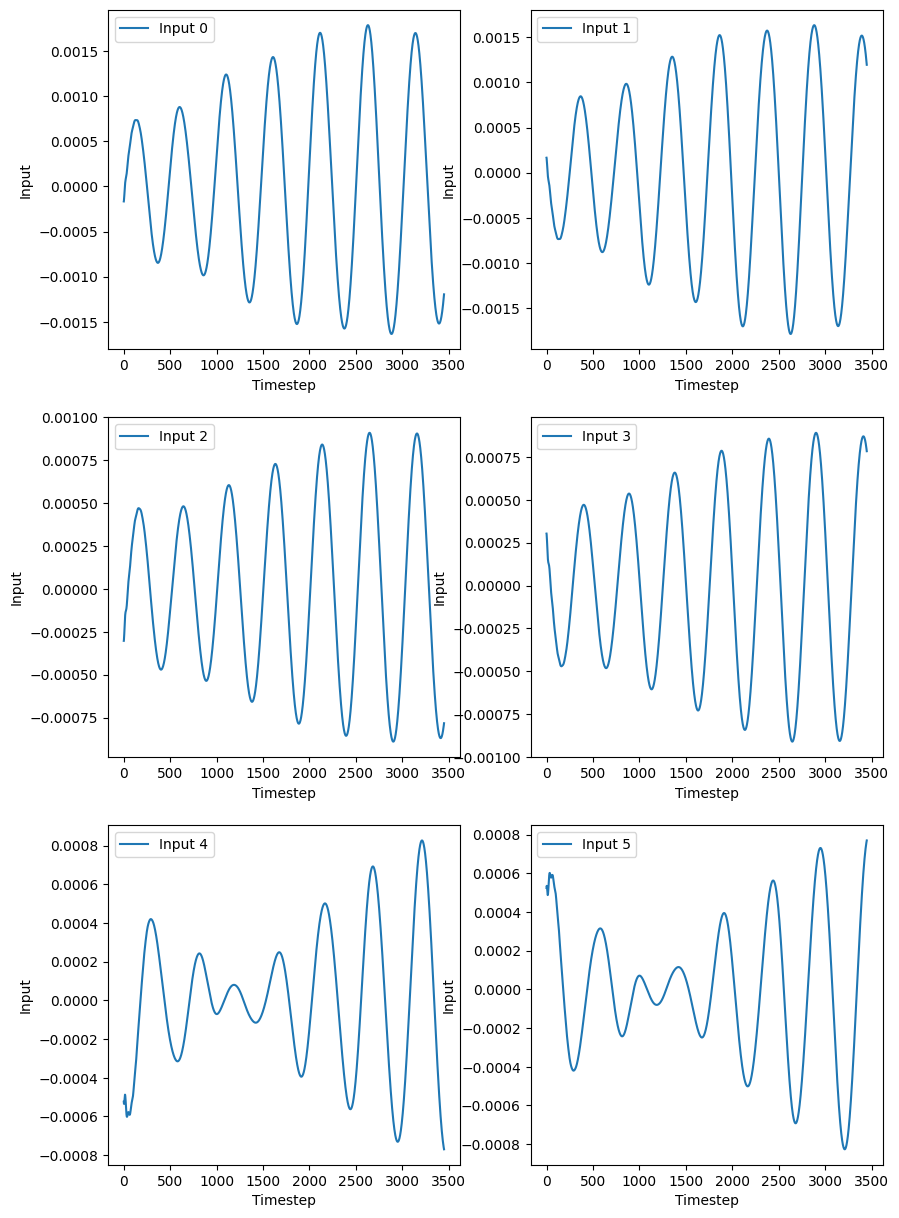

In [76]:
# Plot all 6 inputs separately on subplots
fig, axs = plt.subplots(3, 2, figsize=(10, 15))
for i in range(6):
    axs[i//2, i%2].plot(U_fom[i,:], label="Input " + str(i))
    axs[i//2, i%2].set_xlabel("Timestep")
    axs[i//2, i%2].set_ylabel("Input")
    axs[i//2, i%2].legend()

## Trajectory Tracking

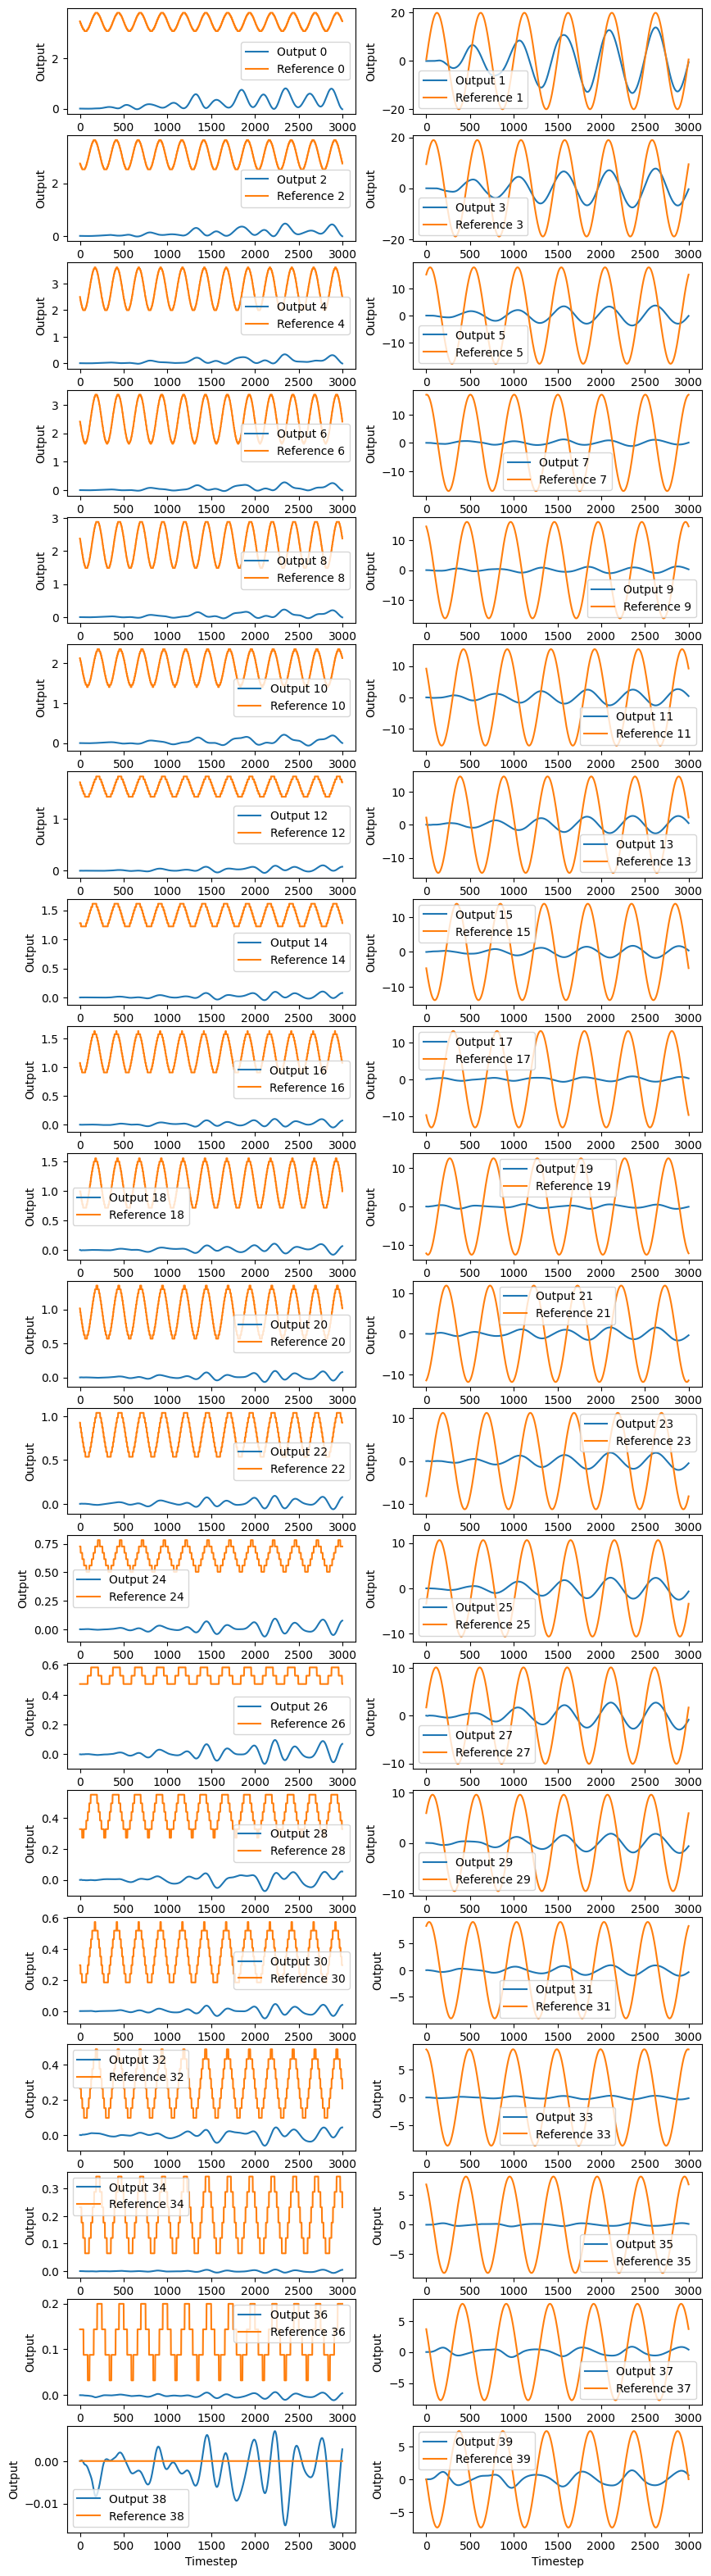

In [77]:
# Show output trajectories against reference trajectories for all 40 outputs
fig, axs = plt.subplots(20,2, figsize=(10, 40))
plotTimetsteps = 3000
for i in range(40):
    axs[i//2, i%2].plot(y_groundTruth_online[i,:plotTimetsteps], label="Output " + str(i))
    axs[i//2, i%2].plot(y_ref_online[i,:plotTimetsteps], label="Reference " + str(i))
    axs[i//2, i%2].set_xlabel("Timestep")
    axs[i//2, i%2].set_ylabel("Output")
    axs[i//2, i%2].legend()

### Tracking video

In [78]:
# Generate video of output centerline trajectories against reference centerline trajectories 
animationFilepath = filepath + "outputCenterlineTrajectories.mp4"
numFrames = timesteps-5
fps = 60
duration = numFrames/fps
# Set up figure for animation
fig, ax = plt.subplots()
# Animation callback
def animate(t):
    global y_groundTruth_online, y_ref_online, Y0_fom
    i = int(round(t*fps))
    ax.clear()
    # Reshape outputs
    output_i = y_groundTruth_online[:,i].reshape((20,2))
    output_i[:,0] = output_i[:,0] +  Y0_fom.reshape((20,2))[:,0] # Only offset the x coordinate
    ref_i = y_ref_online[:,i].reshape((20,2))
    ref_i[:,0] = ref_i[:,0] +  Y0_fom.reshape((20,2))[:,0] # Only offset the x coordinate
    ax.plot(-ref_i[:,0], ref_i[:,1], label="Reference", linewidth = 5, color = 'red', linestyle='dashed', ) # flip x sign to make things look nicer
    ax.plot(-output_i[:,0], output_i[:,1], label="Output", linewidth = 5, color = 'k') # flip x sign to make things look nicer
    ax.set_xlabel("x [mm]")
    ax.set_ylabel("z [mm]")
    # Set axis limits
    ax.set_ylim([-7, 7])
    # ax.set_xlim([-5, 2000])
    ax.set_title("Timestep: " + str(i))
    ax.legend()
    return mplfig_to_npimage(fig)

animation = VideoClip(animate, duration=duration)
animation.write_videofile(animationFilepath, fps=fps)

Moviepy - Building video /home/brdl/iman/dev/sofaProjects/anguilliformOptimalControl/data/verificationData/controlTest26/outputCenterlineTrajectories.mp4.
Moviepy - Writing video /home/brdl/iman/dev/sofaProjects/anguilliformOptimalControl/data/verificationData/controlTest26/outputCenterlineTrajectories.mp4



t:  56%|█████▋    | 1692/2995 [01:46<01:38, 13.19it/s, now=None]

### Tracking Error